# ParFlow Short Course: Gridding
## Exercise: Gridding with a Box Domain

### Problem Description
We will be working with a simple 2D box cross section domain with the following characteristics:
 - A cross section through a "box domain"
 - The domain consists of a single row of 20 cells (each of which are $100m$ long and $2m$ wide) with 10 vertical layers of (potentially) varying thickness that extend to a total thickness of $48m$
 - The domain slopes from right to left with a constant slope of $0.1$ (rise/run)
 - The subsurface is homogeneous with hydraulic conductivity of $K=1.465e^{-2}(m/h)$
 - Simulations will run for 100 hours with a time step of 1 hour (100 time steps).
 - There are no-flow boundary conditions on all sides except the "upper-x" boundary (i.e. the right boundary) which has a Dirichlet (constant head) boundary condition set to $1m$ below the surface and the top surface which has an overland flow boundary condition 
 - A constant recharge flux of $0.01m/h$ is applied across the top of the domain 
 - The initial head for the entire domain is set to $10m$ below the land surface

### Topics Covered
1. Spatial Gridding
2. Temporal Gridding
3. Block Domain vs. Solid File Domain

#### Tip: Think through the problem
Before running a simple problem domain like this it is a good idea to have some idea about what the domain looks like, and what the initial and final conditions should look like too. Ask yourself, what should change as the model runs? Sketch out the problem as described above on a sheet of paper or tablet. There are a lot of moving parts in a ParFlow simulation so being sure you have a strong conceptual understanding for how these should evolve will ensure _i)_ that domains you build are as you intend them to be, and _ii)_ that the results are plausible/reasonable.

## Topic 1: Spatial Gridding

### Geometries
In ParFlow we use `geometries` to define the elements that make up our problem space. 

First, we declare the names of the `geometries` we plan to define, then we can use these to define various properties. In this case we only have one: `domain`. Next, for each of the declared `geometries` we specify a type and setup names within the geometry. 

### Variable ${\Delta z}$ 
By default ParFlow uses uniform thickness layers but this example uses the variable $\Delta z$ option that allows you to change the thickness of each of your z-layers.  In this example, the "base" `DZ` is $1.0m$ and the `NZ` is 10, meaning the 10 layers would each be 1m thick by default. 

The `dzscale.Value` lines are multipliers (numbers) for each layer. The way this works is that the "base" layer thicknesses we defined, 1m in our case, is multiplied by the scale value to define the actual thickness of each layer in the simulation. Layer 0 refers to the bottom layer which means that the bottom layer will have a thickness of 10m (10 * 1m)  and the top layer (9) with a scale value of .1 will have a thickness of 0.1m (.1 * 1m)

### Activities
You will explore how different spatial grid conditions affect the conditions of a ParFlow run. To simplify the view to just the keys we are focusing on, the following notebook cells set up a ParFlow run by importing a ParFlow run definition database; this is only possible using the Python interface, and is not supported in the TCL interface.  Please see [box_domain_setup_full.ipynb](https://github.com/hydroframe/parflow_short_course_updated/blob/main/gridding/box_domain_setup_full.ipynb) if you would like to see the full set of keys used to define the domain for this ParFlow run. Keep in mind that ParFlow always uses the last instance we set for a key so anything set herein is technically _replacing_ whatever was set in the box_domain example. In this section we are focusing on the ParFlow keys related to the [Computational Grid](https://parflow.readthedocs.io/en/latest/keys.html#computational-grid), [Domain Geometry](https://parflow.readthedocs.io/en/latest/keys.html#geometries), and [dz Multipliers](https://parflow.readthedocs.io/en/latest/keys.html#dzmultipliers). We will explain these keys in more detail in the cells below. Also feel free to explore the [ParFlow manual](https://parflow.readthedocs.io/en/latest/keys.html#) for detail on all ParFlow keys.

We'd like for you to first run the notebook cells in this section as-is to see the default box domain visualized. Then you will experiment with changing several of the ParFlow keys to see how the resulting grid changes. As you do this, always ask yourself what you think should happen before you run, then evaluate what actually happened.  

Please complete the following:
1. Run the following notebook cells in this section without modifications. What characteristics do you notice about the grids presented in the plots?  
1. Experiment with changing the number and size of the grid cells by redefining the related ParFlow keys and re-running the notebook. How does the ParFlow grid change as a result?  
    1. Keys for the number of grid cells: `ComputationalGrid.NX`, `ComputationalGrid.NY`, `ComputationalGrid.NZ`
    1. Keys for the size of grid cells: `ComputationalGrid.DX`, `ComputationalGrid.DY`, `ComputationalGrid.DZ`
1. Experiment with restricting only part of the domain to be in the "active" region. This means that the ParFlow grid only considers this region when solving. Do this by setting `Geom.domain.Upper.X` to be half of what it was previously. Re-run the notebook cells and notice how the ParFlow grid changes as a result.
1. Experiment with the differences between a constant dz and a variable dz. This can be done by setting the ParFlow key `Solver.Nonlinear.VariableDz` to `True`. We have pre-defined some depth levels in the ParFlow keys `Cell._0.dzScale.Value` to `Cell._9.dzScale.Value`. Compare the visual of the grid before and after this change is made while keeping the total thickness the same. What do you notice about the resulting grid cell spacing?

In [21]:
# Import the ParFlow package
from parflow import Run
import os
import sys
from parflow.tools.fs import mkdir, cp, chdir, get_absolute_path, rm, exists
from scipy.optimize import fsolve

# Import functions for plotting
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../plots")))
from plots import plot_domain, plot_vert_var, plot_vert_var_combined

# Import run information from pfidb
domain_example = Run.from_definition("domain_example.pfidb")

simulation_name = 'unsaturated_column'       #simulation: wetting - wetting front propagation, unsaturated_column - soil column example

In [22]:
#-----------------------------------------------------------------------------
# Computational Grid
#-----------------------------------------------------------------------------

# Coordinates (length units)
# Locate the origin in the domain.
domain_example.ComputationalGrid.Lower.X = 0.0
domain_example.ComputationalGrid.Lower.Y = 0.0
domain_example.ComputationalGrid.Lower.Z = 0.0

# Cell size (length units)
domain_example.ComputationalGrid.DX      = 100.0
domain_example.ComputationalGrid.DY      = 1.0
domain_example.ComputationalGrid.DZ      = 0.01

# Grid dimensions (integer)
domain_example.ComputationalGrid.NX      = 1
domain_example.ComputationalGrid.NY      = 1
domain_example.ComputationalGrid.NZ      = 1000

#-----------------------------------------------------------------------------
# Domain Geometry Input
#-----------------------------------------------------------------------------
domain_example.GeomInput.domain_input.InputType = 'Box'
domain_example.GeomInput.domain_input.GeomName  = 'domain'

#-----------------------------------------------------------------------------
# Domain Geometry
#-----------------------------------------------------------------------------
domain_example.Geom.domain.Lower.X = 0.0
domain_example.Geom.domain.Lower.Y = 0.0
domain_example.Geom.domain.Lower.Z = 0.0

domain_example.Geom.domain.Upper.X = 2000.0
domain_example.Geom.domain.Upper.Y = 2.0
domain_example.Geom.domain.Upper.Z = 10.0

domain_example.Geom.domain.Patches = 'x_lower x_upper y_lower y_upper z_lower z_upper'

#--------------------------------------------
# Variable dz Assignments
#------------------------------------------
domain_example.Solver.Nonlinear.VariableDz = False
domain_example.dzScale.GeomNames           = 'domain'
domain_example.dzScale.Type                = 'nzList'
domain_example.dzScale.nzListNumber        = 10

#-----------------------------------------------------------------------------
# Mobility
#-----------------------------------------------------------------------------
domain_example.Phase.water.Mobility.Type  = 'Constant'
domain_example.Phase.water.Mobility.Value = 1.0

#-----------------------------------------------------------------------------
# Relative Permeability
#-----------------------------------------------------------------------------
Saturation_N = 2; RelPerm_N = 2
domain_example.Phase.RelPerm.Type        = 'VanGenuchten'
domain_example.Phase.RelPerm.GeomNames   = 'domain'

domain_example.Geom.domain.RelPerm.Alpha = 1.0
domain_example.Geom.domain.RelPerm.N     = RelPerm_N#1000.0#2.0

#---------------------------------------------------------
# Saturation
#---------------------------------------------------------
domain_example.Phase.Saturation.Type        = 'VanGenuchten'
domain_example.Phase.Saturation.GeomNames   = 'domain'

domain_example.Geom.domain.Saturation.Alpha = 1.0
domain_example.Geom.domain.Saturation.N     = Saturation_N#1000.0#2.0
domain_example.Geom.domain.Saturation.SRes  = 0.2
domain_example.Geom.domain.Saturation.SSat  = 1.0

#---------------------------------------------------
# Initial conditions: water pressure
#---------------------------------------------------

domain_example.ICPressure.Type                 = 'Constant'#'HydroStaticPatch'
domain_example.ICPressure.GeomNames            = 'domain'

if simulation_name == 'wetting':
    domain_example.Geom.domain.ICPressure.Value    = -100.0#Almost Dry
else:
    s_s = 1.0; s_r = 0.2 #Saturation saturated and residual
    sat_init = 0.7
    alpha_vG = 1.0
    Ks = 0.01465 #Saturated hydraulic conductivity = 0.01465 m/h
    sw_vG= lambda h,n: (s_s - s_r)/((1 + abs(alpha_vG*h)**n)**(1-1/n))+s_r #sw, head in cms

    h_from_sat = lambda h: sw_vG(h,Saturation_N) - sat_init
    h_init = fsolve(h_from_sat,1,xtol=1e-10)
    print('Initial head',abs(h_init), 'm')
    print('Initial saturation',sw_vG(-abs(h_init),Saturation_N))


    domain_example.Geom.domain.ICPressure.Value    = -abs(h_init[0]) #Almost Dry


domain_example.Geom.domain.ICPressure.RefGeom  = 'domain'
domain_example.Geom.domain.ICPressure.RefPatch = 'z_upper'

#-----------------------------------------------------------------------------
# Boundary Conditions: Pressure
#-----------------------------------------------------------------------------
domain_example.BCPressure.PatchNames = 'x_lower x_upper y_lower y_upper z_lower z_upper'

domain_example.Patch.y_lower.BCPressure.Type          = 'FluxConst'
domain_example.Patch.y_lower.BCPressure.Cycle         = 'constant'
domain_example.Patch.y_lower.BCPressure.alltime.Value = 0.0

domain_example.Patch.z_lower.BCPressure.Type = 'FluxConst'
domain_example.Patch.z_lower.BCPressure.Cycle         = 'constant'
domain_example.Patch.z_lower.BCPressure.alltime.Value = 0.0

domain_example.Patch.x_lower.BCPressure.Type          = 'FluxConst'
domain_example.Patch.x_lower.BCPressure.Cycle         = 'constant'
domain_example.Patch.x_lower.BCPressure.alltime.Value = 0.0

domain_example.Patch.x_upper.BCPressure.Type          = 'FluxConst'
domain_example.Patch.x_upper.BCPressure.Cycle         = 'constant'
domain_example.Patch.x_upper.BCPressure.alltime.Value = 0.0

domain_example.Patch.y_upper.BCPressure.Type          = 'FluxConst'
domain_example.Patch.y_upper.BCPressure.Cycle         = 'constant'
domain_example.Patch.y_upper.BCPressure.alltime.Value = 0.0

domain_example.Patch.z_upper.BCPressure.Type          = 'FluxConst'
domain_example.Patch.z_upper.BCPressure.Cycle         = 'constant'

if simulation_name == 'wetting':
    s_s = 1.0; s_r = 0.2 #Saturation saturated and residual
    sat_init = 0.7
    m = 1-1/RelPerm_N

    se_vG= lambda sw: ((sw - s_r)/(s_s - s_r))
    Ks = 0.01465 #Saturated hydraulic conductivity = 0.01465 m/h
    kr_sat_vG= lambda sw: se_vG(sw)**(1/2)*(1-(1-se_vG(sw)**(1/m))**m)**2

    domain_example.Patch.z_upper.BCPressure.alltime.Value = -0.005#-Ks * kr_sat_vG(sat_init)
else:
    domain_example.Patch.z_upper.BCPressure.alltime.Value = 0.0000

#---------------------------------------------------------
# Topo slopes in x-direction
#---------------------------------------------------------
domain_example.TopoSlopesX.Type              = 'Constant'
domain_example.TopoSlopesX.GeomNames         = 'domain'
domain_example.TopoSlopesX.Geom.domain.Value = 0.0  #slope in X-direction to allow ponded water to run off

#---------------------------------------------------------
# Topo slopes in y-direction
#---------------------------------------------------------
domain_example.TopoSlopesY.Type              = 'Constant'
domain_example.TopoSlopesY.GeomNames         = 'domain'
domain_example.TopoSlopesY.Geom.domain.Value = 0.0

#-----------------------------------------------------------------------------
# Run ParFlow
#-----------------------------------------------------------------------------
base = os.path.join(os.getcwd(), "output")
os.environ["PARFLOW_DIR"] = "/home/SHARED/software/parflow/3.10.0/" 
mkdir(base)
print(f"base: {base}")
domain_example.run(working_directory=base)

Initial head [0.99503024] m
Initial saturation [0.7]
base: /home/ms6985/ParFlow-project/Gridding/output

# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/3.10.0/
# ParFlow version
#  - 3.10.0
# Working directory
#  - /home/ms6985/ParFlow-project/Gridding/output
# ParFlow database
#  - domain_example.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================



Now let's take a look at the ParFlow grid. We will visualize how saturation and pressure vary within the defined grid.

In [23]:
'''
# Call plotting function for saturation and pressure
plot_domain(base, "satur", timestep=0)
#plot_domain(base, "press", timestep=0)
from plots import plot_vert_var
plot_vert_var(base, "press", timestep=0)
plot_vert_var(base, "satur", timestep=0)
'''

'\n# Call plotting function for saturation and pressure\nplot_domain(base, "satur", timestep=0)\n#plot_domain(base, "press", timestep=0)\nfrom plots import plot_vert_var\nplot_vert_var(base, "press", timestep=0)\nplot_vert_var(base, "satur", timestep=0)\n'

## Topic 2: Temporal Gridding

### Timing
The units of time are set by the *hydraulic conductivity*, $K$ has dimensions of $[L/T]$ and we defined $K=1.465e^{-2} (m/h)$, so in the case our units are *hours*. 


**Base Unit:** This specifies the base unit of time for all *Time Cycle* values (see below).  This is like a conversion between the *time step* and the cycle intervals. Time cycles intervals are expressed as multiples of this value. To keep things simple here we set it to 1.0. Because we expressed our hydraulic conductivity in units of $[m/hr]$ in this example this means that our base unit of time is 1 *h*.

**Start Count:** The time step number that your first output (the initial condition) will use.  Because we are starting from an initial condition we set this to 0. If we were restarting a run we would set this to the last output interval from your previous simulation.

**Start and Stop times:**  `StartTime` and `StopTime` specify the start and stop times for the simulation in units of *h*. These values should correspond with the forcing files you are using. Here the stop time is set to 72 hours or three days adn we start at time $t=0$. If we were running longer or restarting a simulation these values might change. These _are not_ directly linked to the start count, but are used when determining which time cycle the simulation is in. 

**Dump Interval:** This key specifies the timing interval at which ParFlow time-dependent outputs will be written.  A positive value for dump interval will be interpreted as a time interval (in this case a real, or float in hours), a negative value says to output every iteration of solver, which is not commonly used except when debugging. Here we set `DumpInterval` to 1.0 *h* so we will have outputs written hourly. Even if the solver subdivides its time steps because of non-convergence, we will only get outputs generated every hour after enough time steps have converged. 

**Time Step:** This is the $\Delta t$ used to advance our simulation in time. Here we use a constant time step of 1.0 *h*.

**Time Cycles:**  Cycles allow us to define time spans where specific boundary conditions are applied, including wells, Dirichlet boundaries, etc... For example if you aren’t running with CLM and you would like to have periods with rain and periods without, cycles allow you to do this easily and without needing any files. Here, we have only one time cycle because we will be using CLM to handle the temporally variable forcings. Therefore, we specify one time cycle and it is treated as a constant for the duration of the simulation. We accomplish this by giving it a repeat value of -1, which repeats indefinitely. The length of the cycle is the length specified below (an integer) multiplied by the base unit value we specified earlier.

### Activities
You will explore how different temporal grid conditions affect the conditions of a ParFlow run. The following notebook cells set up a ParFlow run by importing a ParFlow run definition, run ParFlow for 100 timesteps, and visualize the resulting ParFlow run grid. Please see [box_domain_setup_full.ipynb](https://github.com/hydroframe/parflow_short_course_updated/blob/main/gridding/box_domain_setup_full.ipynb) if you would like to see the full set of keys used to define the domain for this ParFlow run. In this section we are focusing on the ParFlow keys related to [Timing](https://parflow.readthedocs.io/en/latest/keys.html#timing-information). We will explain these keys in more detail in the cells below. Also feel free to explore the [ParFlow manual](https://parflow.readthedocs.io/en/latest/keys.html#) for detail on all ParFlow keys.

As before, first run the notebook cells in this section as-is to see the default box domain visualized. Then you will experiment with changing several of the ParFlow keys to see how the resulting grid changes.

Please complete the following:
1. Run the following notebook cells in this section as-is. What characteristics do you notice about the grids presented in the plots?  
1. Experiment with changing the start and stop times for the run using the keys `TimingInfo.StartTime` and `TimingInfo.StopTime`. Review the time series plot and compare how the outputs change as these key values change.

In [24]:
# Import run information from pfidb
#domain_example = Run.from_definition("domain_example.pfidb")

#-----------------------------------------------------------------------------
# Setup Timing
#-----------------------------------------------------------------------------

# Sets time units for time cycles (T)
domain_example.TimingInfo.BaseUnit     = 1.0

# Initial output file number
domain_example.TimingInfo.StartCount   = 0

# Start and finish time for simulation (T)
domain_example.TimingInfo.StartTime    = 0.0

if simulation_name == 'wetting':
    domain_example.TimingInfo.StopTime     = 1000.0

    # Interval to write output (T) -1 outputs at every timestep
    domain_example.TimingInfo.DumpInterval = 10.0

else:
    domain_example.TimingInfo.StopTime     = 100.0

    # Interval to write output (T) -1 outputs at every timestep
    domain_example.TimingInfo.DumpInterval = 1.0

# Timestep type
domain_example.TimeStep.Type           = 'Constant'

# Delta T (T)
domain_example.TimeStep.Value          = 1.0

#-----------------------------------------------------------------------------
# Time Cycles
#-----------------------------------------------------------------------------
domain_example.Cycle.Names = 'constant'
domain_example.Cycle.constant.Names = 'alltime'
domain_example.Cycle.constant.alltime.Length = 1
domain_example.Cycle.constant.Repeat = -1

#-----------------------------------------------------------------------------
# Run ParFlow
#-----------------------------------------------------------------------------
base = os.path.join(os.getcwd(), "output")
mkdir(base)
print(f"base: {base}")
domain_example.run(working_directory=base)

base: /home/ms6985/ParFlow-project/Gridding/output

# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/3.10.0/
# ParFlow version
#  - 3.10.0
# Working directory
#  - /home/ms6985/ParFlow-project/Gridding/output
# ParFlow database
#  - domain_example.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================



nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
x = [  0. 100.], y = [0. 1.], z = [ 0.    0.01  0.02 ...  9.98  9.99 10.  ]
Shapes of : x = (2,), y = (2,), z = (1001,)
0.7
0
nan
nan
0.7
5
nan
nan
0.7
10
nan
nan
0.7
25
nan
nan
0.7
50
nan
nan


/home/ms6985/ParFlow-project/Gridding/plots.py:294: RuntimeWarning: invalid value encountered in divide
  dkrbydsw_vG_analytic= lambda sw: 1/(s_s - s_r) * (0.5*(se_vG(sw))**0.5*((se_vG(sw))**(1/m) - 1)*((1 - (se_vG(sw))**(1/m))**m - 1) + 2*(se_vG(sw))**((0.5*m + 1)/m)*(1 - (se_vG(sw))**(1/m))**m)*((1 - (se_vG(sw))**(1/m))**m - 1)/((se_vG(sw))**1.0*((se_vG(sw))**(1/m) - 1))


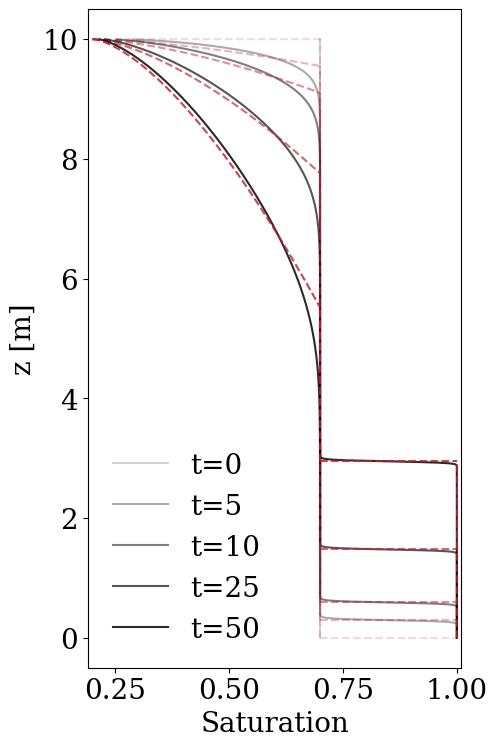

In [25]:
# Call plotting function at multiple timesteps
if simulation_name == 'wetting':
    timesteps = [0, 10,25, 50, 100,250]
else:
    timesteps = [0, 5, 10,25,50]

'''
for t in timesteps:
    #plot_domain(base, "satur", timestep=t)
    plot_vert_var(base, "satur", timestep=t)
'''
plot_vert_var_combined(base, "satur", timesteps,RelPerm_N,Saturation_N,simulation_name)


## Topic 3: Working from a Solid File

The crater_2d example is a basic example of "deactivating" a portion of the domain using a solid file to mask off part of the domain. A solid file is a 3d object that is independent of the computational grid than can be used to define a geometry. Only cells inside the volume of the solid are part of the geometry, and we often use these to define geological units or the extents of a watershed. The crater 2d example masks off a small wedge of the box domain we've been working with, so in this case the solid file is only used to define the active simulation domain and not to define any particular parameters. An important point is that boundaries must be defined on whatever geometry is used to set the active domain via the `Domain.GeomName` key.  

### Activities

You will explore how using a solid file to define the domain affects the conditions of a ParFlow run. The following notebook cells set up a ParFlow run by importing a ParFlow run definition, run ParFlow for 100 timesteps, and visualize the resulting ParFlow run grid. Please see [crater_domain_setup_full.ipynb](https://github.com/hydroframe/parflow_short_course_updated/blob/main/gridding/crater_domain_setup_full.ipynb) if you would like to see the full set of keys used to define the domain for this ParFlow run. In this section we are focusing on the ParFlow keys related to [Geometries](https://parflow.readthedocs.io/en/latest/keys.html#geometries). We will explain these keys in more detail in the cells below. Also feel free to explore the [ParFlow manual](https://parflow.readthedocs.io/en/latest/keys.html#) for detail on all ParFlow keys.


Please complete the following:
1. Run the following notebook cells in this section as-is. The first ParFlow run utilizes a box domain while the second ParFlow run defines the domain with the use of a solid file. What differences do you notice between these two domain definitions?

In [26]:
# Import the ParFlow package
from parflow import Run
import os
from parflow.tools.fs import mkdir, cp, chdir, get_absolute_path, rm, exists

# Import run information from pfidb
crater = Run.from_definition("crater.pfidb")

First we run the Crater 2D domain as defined using `InputType = 'Box'`.

In [27]:
#---------------------------------------------------------
# The Names of the GeomInputs
#---------------------------------------------------------
Zones = "zone1 zone2 zone3above4 zone3left4 zone3right4 zone3below4 zone4"
crater.GeomInput.Names = f'domain_input {Zones} background'

crater.GeomInput.domain_input.InputType = 'Box'
crater.GeomInput.domain_input.GeomName  = 'domain'

crater.Geom.domain.Lower.X = 0.0
crater.Geom.domain.Lower.Y = 0.0
crater.Geom.domain.Lower.Z = 0.0

crater.Geom.domain.Upper.X = 400.0
crater.Geom.domain.Upper.Y = 1.0
crater.Geom.domain.Upper.Z = 200.0

crater.Geom.domain.Patches = 'z_upper x_lower y_lower x_upper y_upper z_lower'

# Run the model
base = os.path.join(os.getcwd(), "output")
mkdir(base)
print(f"base: {base}")
crater.run(working_directory=base)

base: /home/ms6985/ParFlow-project/Gridding/output

# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/3.10.0/
# ParFlow version
#  - 3.10.0
# Working directory
#  - /home/ms6985/ParFlow-project/Gridding/output
# ParFlow database
#  - crater.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully
# ==============================================================================



nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: -0.9950302369525119, vmax: -0.9950302369525119


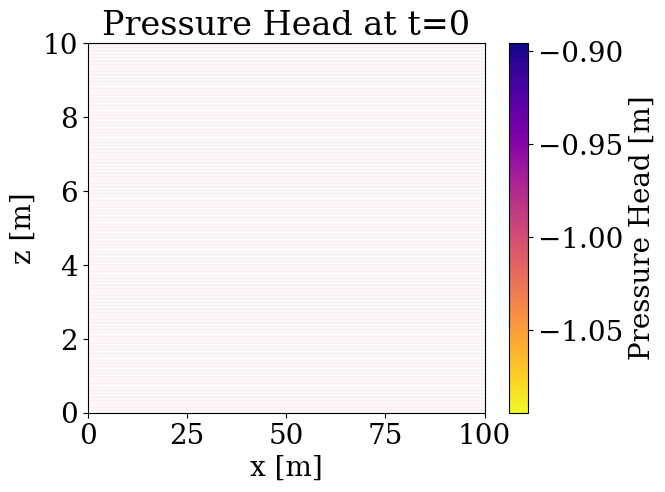

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: 0.6999999999999993, vmax: 0.6999999999999993


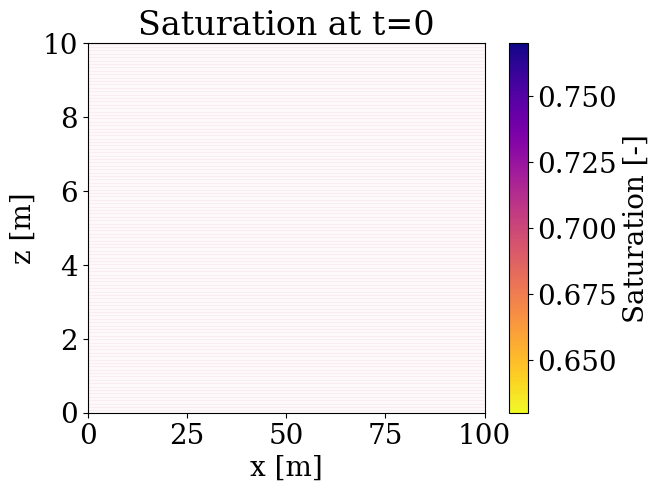

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: -1.0210330799995535, vmax: -0.7081452646992646


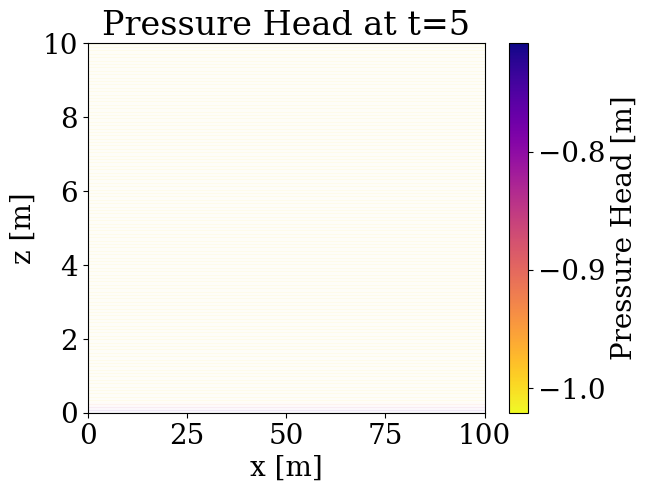

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: 0.2906996211012938, vmax: 0.9999999999999991


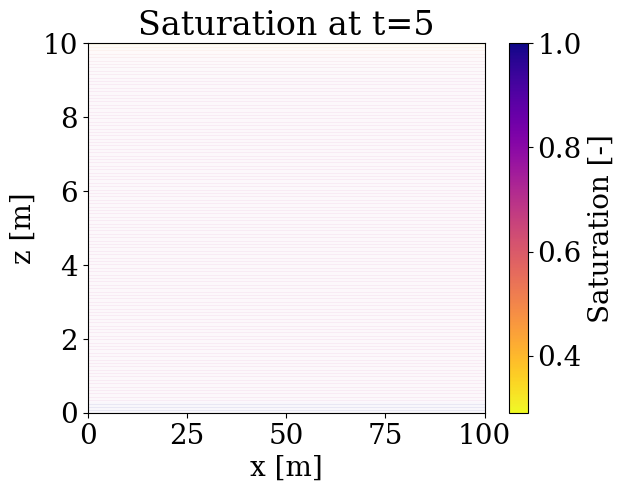

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: -1.0269300850121446, vmax: -0.41302536526676525


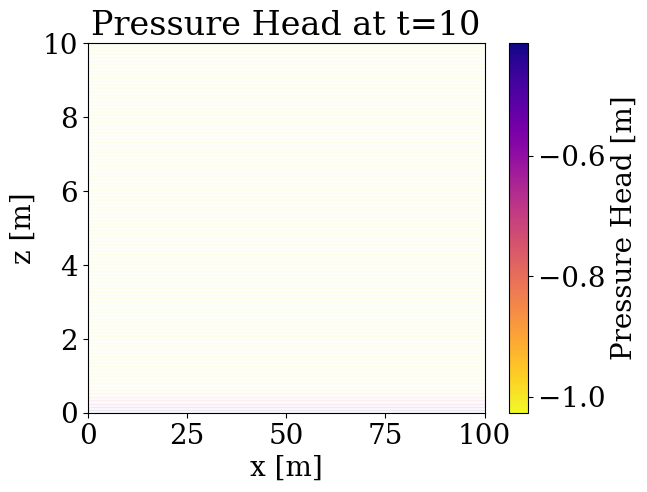

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: 0.2538766304204047, vmax: 1.0


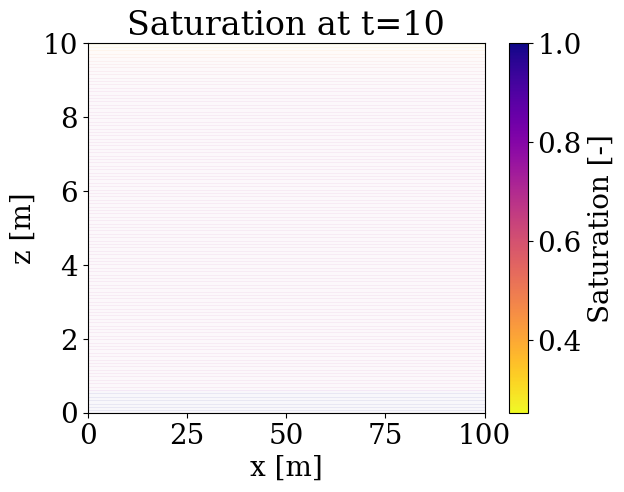

In [28]:
# Call plotting function at multiple timesteps
timesteps = [0, 5, 10]

for t in timesteps:
    plot_domain(base, "press", timestep=t)
    plot_domain(base, "satur", timestep=t)

Next we run the Crater 2D domain as defined using `InputType = 'SolidFile'`.

In [29]:
#---------------------------------------------------------
# The Names of the GeomInputs
#---------------------------------------------------------

crater.GeomInput.Names = f'solidinput {Zones} background'
crater.GeomInput.solidinput.InputType = 'SolidFile'
crater.GeomInput.solidinput.GeomNames = 'domain'
crater.GeomInput.solidinput.FileName = 'crater2D.pfsol'

# Add the "infiltration" patch (the solid file has 7 patches)
crater.Geom.domain.Patches = 'infiltration z_upper x_lower y_lower x_upper y_upper z_lower'
crater.BCPressure.PatchNames = crater.Geom.domain.Patches

crater.Patch.infiltration.BCPressure.Type = 'FluxConst'
crater.Patch.infiltration.BCPressure.Cycle = 'onoff'
crater.Patch.infiltration.BCPressure.on.Value = -0.10
crater.Patch.infiltration.BCPressure.off.Value = 0.0

crater.Geom.infiltration.ICPressure.Value = 10.0
crater.Geom.infiltration.ICPressure.RefPatch = 'infiltration'
crater.Geom.infiltration.ICPressure.RefGeom = 'domain'

# Run the model
base = os.path.join(os.getcwd(), "output")
cp("crater2D.pfsol", base)
mkdir(base)
print(f"base: {base}")
crater.run(working_directory=base)

Source and destination represents the same file.
base: /home/ms6985/ParFlow-project/Gridding/output

# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/3.10.0/
# ParFlow version
#  - 3.10.0
# Working directory
#  - /home/ms6985/ParFlow-project/Gridding/output
# ParFlow database
#  - crater.pfidb
# ==============================================================================




# ==============================================================================
# ParFlow ran successfully
# ==============================================================================



nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: -0.9950302369525119, vmax: -0.9950302369525119


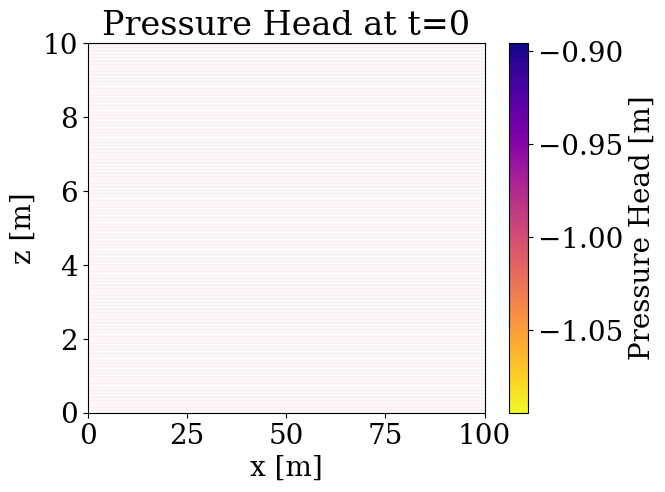

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: 0.6999999999999993, vmax: 0.6999999999999993


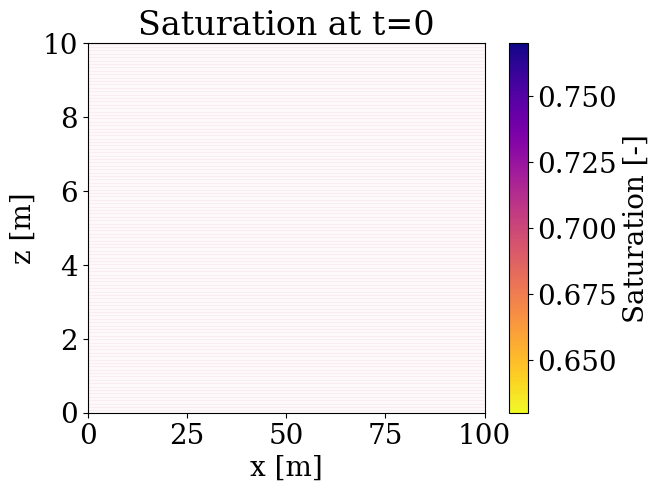

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: -1.0210330799995535, vmax: -0.7081452646992646


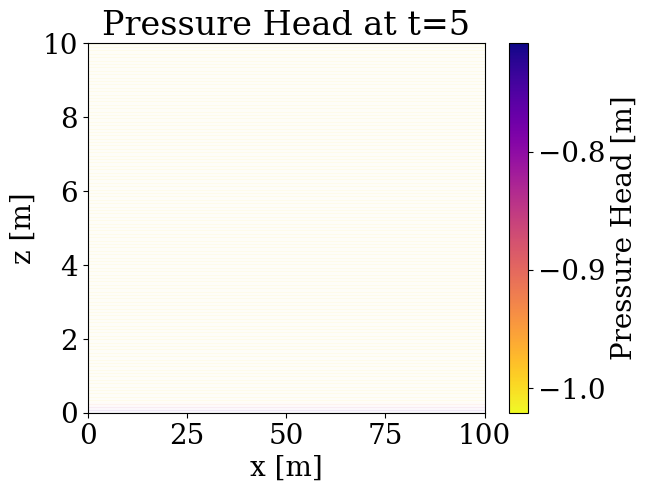

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: 0.2906996211012938, vmax: 0.9999999999999991


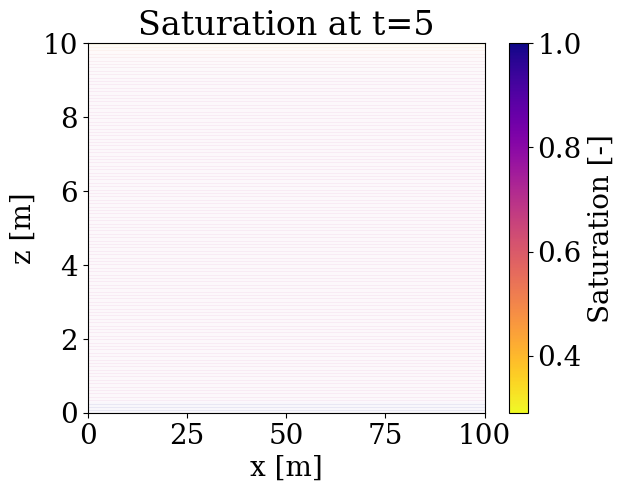

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: -1.0269300850121446, vmax: -0.41302536526676525


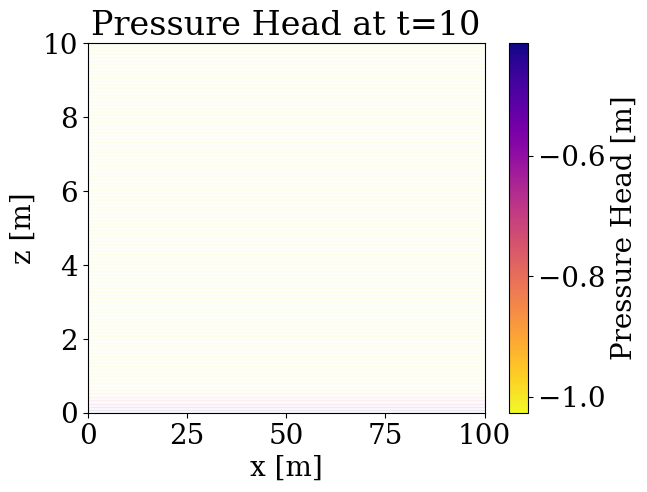

nx = 1, ny = 1, nz = 1000, nt = 101
dx = 100.0, dy = 1.0, dz = 0.01
vmin: 0.2538766304204047, vmax: 1.0


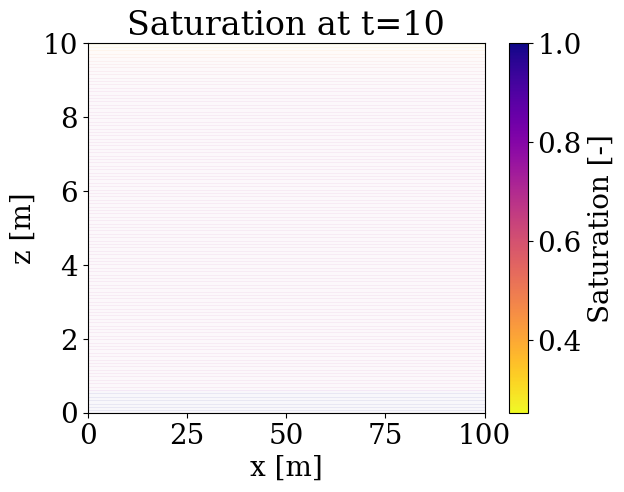

In [30]:
# Call plotting function at multiple timesteps
timesteps = [0, 5, 10]

for t in timesteps:
    plot_domain(base, "press", timestep=t)
    plot_domain(base, "satur", timestep=t)

The key here is to recognize what changes between these two versions. Switch back and forth between them if you need to, but you should see a clear change in a particular corner of the domain. 